# SurvSHAP(t): Time-Dependent Explanations Of Machine Learning Survival Models
### M. Krzyziński, M. Spytek, H. Baniecki, P. Biecek
## Experiment 3: Real-world use case: predicting survival of patients with heart failure
(https://github.com/MI2DataLab/survshap/blob/main/exp3.ipynb)

#### Imports

In [20]:
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from abc import ABC
import torchtuples as tt
from plotly.figure_factory import np
from pycox.models import DeepHitSingle
from sksurv.functions import StepFunction
from survshap import SurvivalModelExplainer, PredictSurvSHAP
import timeit
from captum.attr import DeepLift

#### Preparing data and models 

In [4]:
real_data = pd.read_csv("data/exp3_heart_failure_dataset.csv")
real_data.rename(columns={"DEATH_EVENT": "event"}, inplace=True)

In [5]:
df_train = real_data
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
train_column_names = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine",
                      "serum_sodium", "sex", "smoking"]
max_time = real_data.time.max()

In [6]:
cols_standardize = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]
cols_leave = ['sex', 'smoking']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [7]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [17]:
y_train = (df_train['time'].values, df_train['event'].values)
y_val = (df_val['time'].values, df_val['event'].values)

train = (x_train, y_train)
val = (x_val, y_val)

In [9]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = max_time + 1
batch_norm = True
dropout = 0.1

network = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

    class CustomDeepHitSingle(DeepHitSingle, ABC):
    def __init__(self, net, optimizer=None, device=None, duration_index=None, alpha=0.2, sigma=0.1, loss=None):
        super().__init__(net, optimizer=optimizer, device=device, duration_index=duration_index, alpha=alpha,
                         sigma=sigma, loss=loss)


    def predict_survival_function(self, X, return_array=False):
        preds = self.predict_surv_df(X.values)
        ret = [StepFunction(x=np.arange(0, preds.shape[0]), y=preds[column].values) for i, column in enumerate(preds)]
        return ret

model = CustomDeepHitSingle(network, optimizer=tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=np.arange(0, max_time + 1))

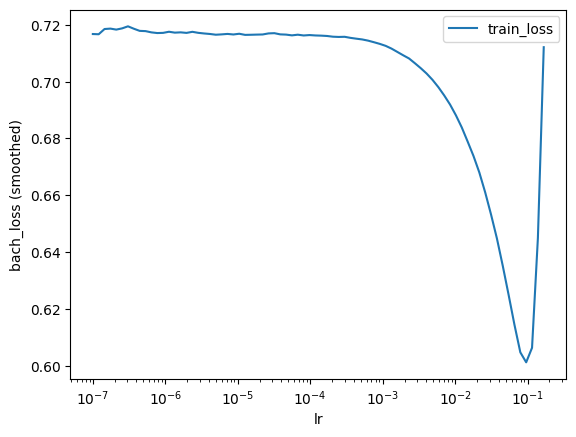

In [10]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [11]:
model.optimizer.set_lr(lr_finder.get_best_lr() * 0.7)

In [12]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.7262,	val_loss: 0.6129
1:	[0s / 0s],		train_loss: 0.6820,	val_loss: 0.6053
2:	[0s / 0s],		train_loss: 0.6510,	val_loss: 0.5984
3:	[0s / 0s],		train_loss: 0.6291,	val_loss: 0.5926
4:	[0s / 0s],		train_loss: 0.6125,	val_loss: 0.5879
5:	[0s / 0s],		train_loss: 0.5927,	val_loss: 0.5848
6:	[0s / 0s],		train_loss: 0.5826,	val_loss: 0.5832
7:	[0s / 0s],		train_loss: 0.5601,	val_loss: 0.5827
8:	[0s / 0s],		train_loss: 0.5507,	val_loss: 0.5823
9:	[0s / 0s],		train_loss: 0.5374,	val_loss: 0.5824
10:	[0s / 0s],		train_loss: 0.5101,	val_loss: 0.5835
11:	[0s / 0s],		train_loss: 0.5017,	val_loss: 0.5848
12:	[0s / 0s],		train_loss: 0.4934,	val_loss: 0.5869
13:	[0s / 0s],		train_loss: 0.4657,	val_loss: 0.5900
14:	[0s / 0s],		train_loss: 0.4601,	val_loss: 0.5956
15:	[0s / 0s],		train_loss: 0.4541,	val_loss: 0.6031
16:	[0s / 0s],		train_loss: 0.4299,	val_loss: 0.6155
17:	[0s / 0s],		train_loss: 0.4144,	val_loss: 0.6361
18:	[0s / 0s],		train_loss: 0.4042,	val_loss: 0.6738


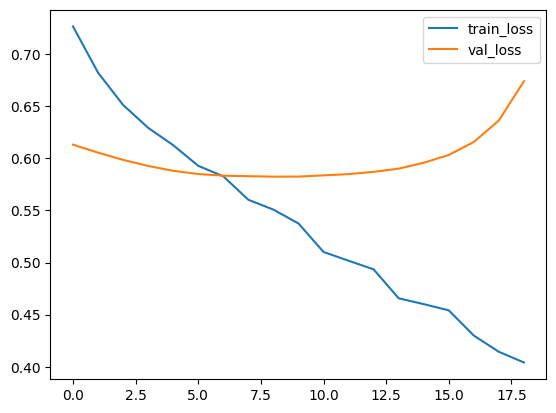

In [13]:
_ = log.plot()

In [48]:
y_dtype = np.dtype({'names':['event', 'time'], 'formats':[np.uint8, np.uint8]})
y = np.array([tuple(row) for row in np.stack((y_train[1], y_train[0])).transpose(1, 0)], dtype=y_dtype)
dl = DeepLift(model.net)
time_array = []
x_test = torch.Tensor(x_test)
baseline = torch.zeros_like(x_test)
pred_idx = model.predict(x_test).argmax(axis=1)

start = timeit.timeit()
attributions, delta = dl.attribute(x_test, baseline, target=pred_idx, return_convergence_delta=True)
end = timeit.timeit()
print(end - start)
time_array.append(end - start)

-0.0012968669980182312


/home/maciej/.local/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning:

Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished



tensor([-0.3553, -0.0614, -0.0621,  0.3124, -0.2414, -0.1846,  0.2679, -0.0991],
       grad_fn=<SelectBackward0>)
tensor(-1.2893)


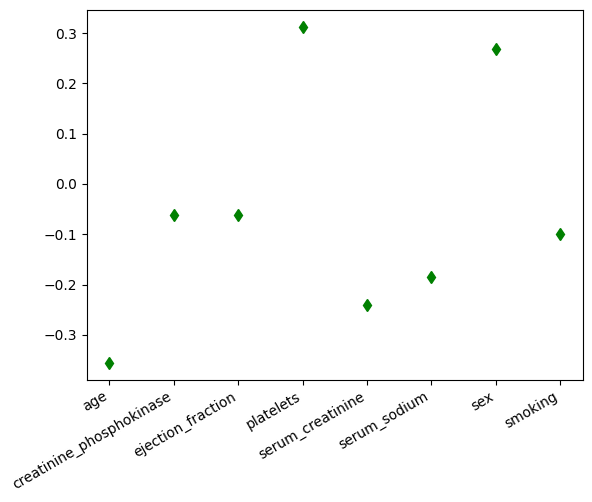

In [58]:
ax= plt.subplot()
plt.plot(train_column_names, attributions[0].detach().numpy(), 'gd')
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(attributions[0])
print(delta[0])